## Model Development for Predicting Medical Appointment Shows  and No Shows

Context

People are calling and scheduling appointments and when given a confirmed time and all the pertient information to accompany them for the the appointment, they fail to show or no show.  Who is at fault for this debacle and how knowing the predictors of this incident could improve perfomance later on.

Content

So, here's the situation, capital city of Espirito Santo State - Vitoria - Brazil, have roughly 300k public healthcare appointments with 15 variables (characteristics) of each. The most important one if the patient show-up or no-show the appointment. The public health adminstration has provided me with all this information including the Variable names which are self-explanatory. I was also made aware that the Handcap is the total amount of handcaps a person presents, and that it was not a binary. The endstate, is for me to conduct various regression on the information provided to see which yeilds the best result.



In [297]:
import os,sys
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
#sns.set_style("whitegrid")
%matplotlib inline

#regression packages
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import statsmodels.formula.api as sm

#lasso regression
from sklearn import linear_model

import dateutil.parser

from sklearn.linear_model import BayesianRidge, LinearRegression

#f_regression (feature selection)
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

# recursive feature selection (feature selection)
from sklearn.feature_selection import RFE

#for validating your classification model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc



When getting started you must first identify your dataset and import your dataset into your tutorial.

## Import Data

In [270]:
df = pd.read_csv('data/KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [271]:
#replace (male to 1, female to 0)
Gender={"male" : "1", "female" :"0"}
df=df.replace({"Gender" : Gender})
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


After data has been imported it needs to be cleaned in order to conduct further ananlysis.  This is where data wrangling comes into place  

# Data wrangling 

In [272]:
#mappling or replacing
df = df.replace({'No-show': 'No'}, {'No-show': '0'})
df = df.replace({'No-show': 'Yes'}, {'No-show': '1'})

In [273]:
#or you can do this to convert object to number
df['No-show'] = df['No-show'].astype(int)
print df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show             int32
dtype: object


In [274]:
#replace (male to 1, female to 0)
mf={"male" : "1", "female" :"0"}
df=df.replace({"Gender" : mf})




Below is an explanation of the Appointments DataFrame attribtues.

- Patientid:
- AppointmentID: 
- Gender: The actual sex of the patient
- scheduleDay: Day and time of appointment 
- AppointmentDay: Day of appointment 
- Age: Actual age of patient
- Neighbourhood: geography of patient living area 
- Scholarship: is government paying for schooling
- Hipertension: 
- Diabetes: 
- Alcholism: 
- Handcap: 
- sms received:text message reminder of appointments 
- Avg no shows:(NS) 
- Appointment Average = NS/SD     

Given this information we will set out to predict which persons are going to show up or not. We will start by removing predictors that are irrelevant in determining if an individual is going to show or not. So with that being said, we will drop the following predictors from this report: PatientID, AppointmentID, sms recieved,Neighbourhood,  

In [275]:
df = df.drop(['Gender', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'PatientId', 'SMS_received', 'Neighbourhood'], axis=1)
df.head(2)

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,No-show
0,62,0,1,0,0,0,0
1,56,0,0,0,0,0,0


In [276]:
# correlation 
df.corr()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,No-show
Age,1.000000,-0.092457,0.504586,0.292391,0.095811,0.078033,-0.060319
Scholarship,-0.092457,1.000000,-0.019729,-0.024894,0.035022,-0.008586,0.029135
Hipertension,0.504586,-0.019729,1.000000,0.433086,0.087971,0.080083,-0.035701
Diabetes,0.292391,-0.024894,0.433086,1.000000,0.018474,0.057530,-0.015180
Alcoholism,0.095811,0.035022,0.087971,0.018474,1.000000,0.004648,-0.000196
Handcap,0.078033,-0.008586,0.080083,0.057530,0.004648,1.000000,-0.006076
No-show,-0.060319,0.029135,-0.035701,-0.015180,-0.000196,-0.006076,1.000000


Which of the predictors have highly significant correlation?

- None

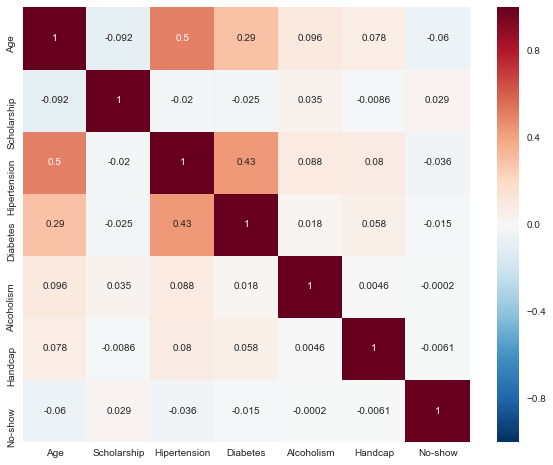

In [277]:
# correlation heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

http://jamesmarquezportfolio.com/correlation_matrices_in_r.html

In [278]:
df.isnull().sum()

Age             0
Scholarship     0
Hipertension    0
Diabetes        0
Alcoholism      0
Handcap         0
No-show         0
dtype: int64

The is great in that it indicate no missing values.

### Here you will learn ways of presenting correlation coefficients

In addition, I have also provided a details regarding this graph for instance:

The predictors that are significantly correlated with age they are:

- Hipertension
- Diabetes

Why is this? This is very relevant in that as people get older they are more succeptable to the aforementioned.


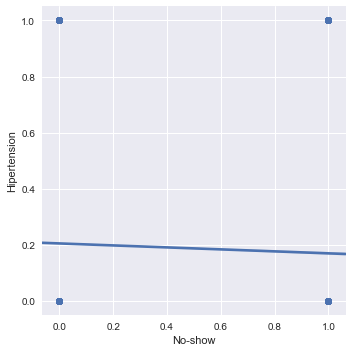

In [311]:
sns.lmplot('No-show', 'Hipertension',df)

- This graph yeiled a negative correlation coefficient meaning that an increase in X is associated with a decrease in Y.



## Model Building 
- at the point we will develop severa different regression models to identify which yeilds the greatest percentage in term No Show. 
- We start by assigning X and y variables.  In the case our y variable will represent No shows, and the remainders will be the predeictors.

In [280]:
#replace (male to 1, female to 0)

df = df.replace({'F': '1'}, {'F': '1'})
df = df.replace({'M': '0'}, {'M': '0'})


In [281]:
#mappling or replacing
df = df.replace({'No-show': 'No'}, {'No-show': '0'})
df = df.replace({'No-show': 'Yes'}, {'No-show': '1'})

In [282]:
#or you can do this to convert object to number
df['No-show'] = df['No-show'].astype(int)
print df.dtypes

Age             int64
Scholarship     int64
Hipertension    int64
Diabetes        int64
Alcoholism      int64
Handcap         int64
No-show         int32
dtype: object


In [283]:
#declare X variables and y variable
y = df['No-show']
X = df.drop(['No-show'], axis=1)


In [306]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: No-show, dtype: int32

In [305]:
X.head()


,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap
0,62,0,1,0,0,0
1,56,0,0,0,0,0
2,62,0,0,0,0,0
3,8,0,0,0,0,0
4,56,0,1,1,0,0


In order to determine the validty of our dataset, it must be trained.  So in order to obtain the best trained results the dataset is split into two different sets a trained portion, and a tested portion.  Listed below are the step in deriving at testing the data. Once the data is validiated it can then be deployed for further testing against variuos regression models such as Ridge Regression, Lasso Regression, etc. to determine which model yeilds the best accucrate results.  Regression models will discussed in depth during the next tutorial.

In [300]:
# evaluate the model by splitting into train (70%) and test sets (30%)
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# name your model as "dt"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [301]:
print X_train.shape, y_train.shape

(74053, 6) (74053L,)


In [302]:
print X_test.shape, y_train.shape

(36474, 6) (74053L,)


In [303]:
X_train.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap
26960,18,0,0,0,0,0
65052,53,0,0,0,0,0
62482,23,1,0,0,0,0
98978,3,0,0,0,0,0
70881,57,0,0,0,0,0


In [309]:
model1_y = model1.predict(X)


References:
- 1) https://www.kaggle.com/joniarroba/noshowappointments
- 2) http://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html#sphx-glr-auto-examples-linear-model-plot-bayesian-ridge-py
- 3) https://docs.python.org/3/library/datetime.html